In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Define custom SVD function
def custom_svd(matrix):
    # Compute ATA
    ATA = matrix.T @ matrix

    # Eigen decomposition of ATA
    eigenvalues, eigenvectors = np.linalg.eigh(ATA)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Handle zero eigenvalues
    nonzero_indices = np.where(eigenvalues > 0)[0]
    eigenvalues = eigenvalues[nonzero_indices]
    eigenvectors = eigenvectors[:, nonzero_indices]

    # Compute Vt
    Vt = eigenvectors.T

    # Compute U
    U = np.zeros_like(matrix)
    for i in range(len(eigenvalues)):
        U[:, i] = (matrix @ eigenvectors[:, i]) / np.sqrt(eigenvalues[i])

    return U, eigenvalues, Vt

In [4]:
# Define custom K-means function
def kmeans(X, k, max_iters=100):
    np.random.seed(42)
    centroids_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[centroids_indices]

    for _ in range(max_iters):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        cluster_labels = np.argmin(distances, axis=0)
        new_centroids = np.array([X[cluster_labels == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids, cluster_labels

In [5]:
# Define function to calculate RMSE
def calculate_rmse(actual_ratings, predicted_ratings):
    mask = actual_ratings != 0
    squared_error = (actual_ratings - predicted_ratings)**2
    mean_squared_error = np.mean(squared_error[mask])
    rmse = np.sqrt(mean_squared_error)
    return rmse

In [6]:
# Data related paths
ratings_path='/content/drive/MyDrive/RS-Jan-2024/Mid Project/ml-1m/ratings.dat'
movies_path='/content/drive/MyDrive/RS-Jan-2024/Mid Project/ml-1m/movies.dat'
users_path='/content/drive/MyDrive/RS-Jan-2024/Mid Project/ml-1m/users.dat'

In [7]:
# Step 1: Import Movielens 1M dataset
ratings_data = pd.read_csv(ratings_path, sep="::", engine="python",
                           names=["userId", "movieId", "rating", "timestamp"])
movies_data = pd.read_csv(movies_path, sep="::", engine="python",
                          names=["movieId", "title", "genres"], encoding="latin1")
users_data = pd.read_csv(users_path, sep="::", engine="python",
                         names=["userId", "gender", "age", "occupation", "zipcode"])

Users Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None

Movies Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None

Ratings Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ---

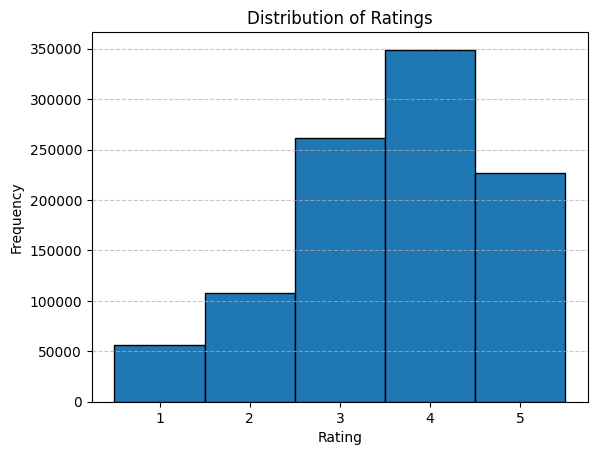

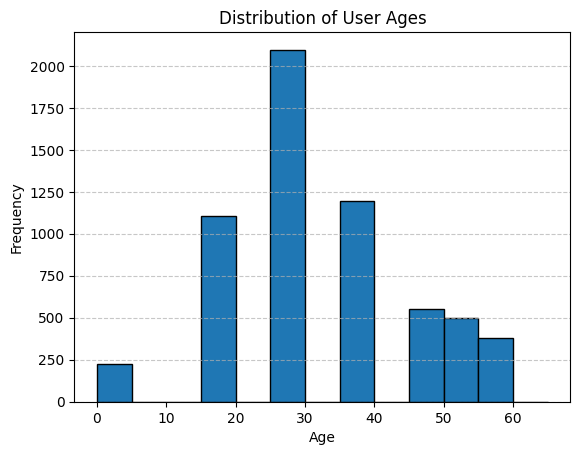

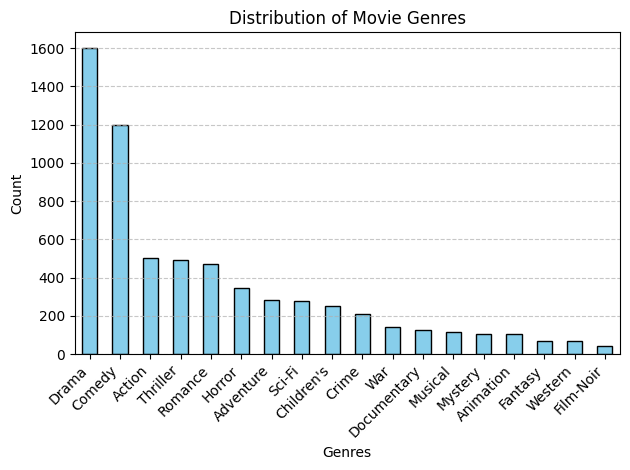

In [8]:
# Display basic information about the datasets
print("Users Dataset:")
print(users_data.info())
print("\nMovies Dataset:")
print(movies_data.info())
print("\nRatings Dataset:")
print(ratings_data.info())

# Summary statistics of ratings
print("\nSummary statistics of ratings:")
print(ratings_data['rating'].describe())

# Plot distribution of ratings
plt.hist(ratings_data['rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot distribution of user ages
plt.hist(users_data['age'], bins=range(0, 70, 5), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of User Ages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot distribution of movie genres
genres_count = movies_data['genres'].str.split('|', expand=True).stack().value_counts()
genres_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
# Step 2: Process Data
# Merge ratings with movies to get movie titles
merged_data = pd.merge(ratings_data, movies_data, on='movieId')

# Create a list of unique genres
all_genres = set()
for genres_str in merged_data['genres']:
    genres = genres_str.split('|')
    all_genres.update(genres)

# Extract relevant user attributes (e.g., age, gender, occupation)
user_attributes = users_data[['userId', 'age', 'gender', 'occupation']]

# Perform one-hot encoding for categorical user attributes
user_attributes = pd.get_dummies(user_attributes, columns=['gender', 'occupation'])

# Create user-item matrix with genres and user attributes
user_ids = merged_data['userId'].unique()
user_item_matrix = pd.DataFrame(0,index=user_ids, columns=list(all_genres))
genre_count_matrix = pd.DataFrame(0, index=user_ids, columns=list(all_genres))

# Fill user-item matrix with average ratings for each genre
# Count the number of movies rated for each genre by each user
for idx, row in merged_data.iterrows():
    user_id = row['userId']
    genres = row['genres'].split('|')
    rating = row['rating']
    for genre in genres:
        user_item_matrix.loc[user_id, genre] += rating
        genre_count_matrix.loc[user_id, genre] += 1

# Avoid division by zero
genre_count_matrix[genre_count_matrix == 0] = 1

# Calculate the average rating for each genre for each user
user_item_matrix /= genre_count_matrix

In [10]:
# Concatenate user attributes with user-item matrix
user_item_with_features = pd.concat([user_item_matrix, user_attributes.set_index('userId')], axis=1)

In [46]:
print(user_item_with_features)
print(user_item_with_features.shape)
print(user_item_with_features.columns)

      Adventure    Sci-Fi   Fantasy       War  Film-Noir  Documentary  \
1      4.000000  4.333333  4.000000  5.000000   0.000000          0.0   
2      3.736842  3.588235  3.000000  3.733333   4.000000          0.0   
12     4.666667  4.000000  0.000000  3.000000   3.000000          0.0   
15     3.173913  3.277778  3.142857  3.769231   2.500000          0.0   
17     4.085714  4.008621  4.444444  4.500000   4.333333          5.0   
...         ...       ...       ...       ...        ...          ...   
3537   2.400000  2.777778  0.000000  2.500000   0.000000          1.0   
2908   5.000000  3.500000  0.000000  0.000000   0.000000          0.0   
2982   2.500000  2.333333  0.000000  0.000000   4.133333          0.0   
3893   1.666667  2.000000  1.000000  3.000000   0.000000          3.0   
4211   2.000000  3.000000  0.000000  2.600000   0.000000          0.0   

      Children's     Crime    Action   Mystery  ...  occupation_11  \
1       4.250000  4.000000  4.200000  0.000000  ...  

In [12]:
# Step 3: Split Data
train_data, test_data = train_test_split(user_item_with_features, test_size=0.2, random_state=42)

In [13]:
print(train_data)

      Adventure    Sci-Fi   Fantasy       War  Film-Noir  Documentary  \
4024   3.000000  3.074074  3.666667  4.750000   4.666667          0.0   
3753   4.000000  3.800000  4.000000  4.600000   2.000000          4.0   
4119   3.833333  4.125000  0.000000  4.250000   0.000000          0.0   
2989   3.454545  3.326923  3.941176  4.384615   3.500000          0.0   
4690   3.400000  3.866667  3.111111  4.000000   3.000000          0.0   
...         ...       ...       ...       ...        ...          ...   
1367   3.709677  3.666667  3.416667  3.909091   5.000000          4.0   
4087   3.000000  3.000000  3.500000  3.000000   0.000000          0.0   
5122   4.500000  4.300000  4.000000  5.000000   0.000000          0.0   
4724   0.000000  0.000000  0.000000  4.500000   4.000000          0.0   
3177   4.333333  4.666667  5.000000  4.500000   4.000000          0.0   

      Children's     Crime    Action  Mystery  ...  occupation_11  \
4024    3.533333  3.000000  2.829268    3.625  ...    

In [17]:
# Step 4: SVD calculation
U, S, Vt = custom_svd(user_item_with_features)

In [19]:
print(U)
print(U.shape)

[[ 2.11190481e-03  2.85302306e-02 -3.09797903e-02 ...  1.41202427e-02
  -1.02109129e-03  0.00000000e+00]
 [ 2.04483817e-02 -2.21358915e-02  3.17926975e-03 ...  1.44880346e-03
  -1.90461854e-03  0.00000000e+00]
 [ 1.01387595e-02  6.62762144e-03 -1.24429889e-02 ...  1.10012229e-03
   5.83064299e-04  0.00000000e+00]
 ...
 [ 9.71223698e-03 -1.92951003e-04 -1.45139245e-03 ...  1.62793322e-02
  -7.17199210e-04  0.00000000e+00]
 [ 9.58414122e-03 -1.74037600e-03 -1.12947239e-03 ... -3.89055947e-02
   2.66775346e-05  0.00000000e+00]
 [ 1.62762863e-02 -2.06707142e-02 -9.10222897e-03 ... -1.81691812e-02
  -3.43735550e-03  0.00000000e+00]]
(6040, 42)


In [28]:
# Determining the Optimal Number of Dimensions using Elbow Method
def find_optimal_k(U, threshold=0.95):
    # total_variance = np.sum(U ** 2)
    # explained_variance_ratio = np.cumsum(U ** 2) / total_variance

    # # Calculate the second derivative of the cumulative explained variance ratio
    # second_derivative = np.diff(np.diff(explained_variance_ratio))

    # # Find the index of the maximum second derivative (elbow point)
    # optimal_k_index = np.argmax(second_derivative) + 1

    # # Get the optimal k value
    # optimal_k = optimal_k_index + 1

    # return optimal_k
    # silhouette_scores = []
    # max_dimensions = min(U.shape[1], 15)  # Maximum number of dimensions to try

    # for k in range(2, max_dimensions + 1):
    #     truncated_U = U[:, :k]
    #     silhouette_scores.append(silhouette_score(truncated_U, truncated_U.argmax(axis=1)))

    # print(silhouette_scores)

    # # Find the optimal number of dimensions (k_reduced) based on the silhouette score
    # optimal_k_reduced = np.argmax(silhouette_scores) + 2  # Add 2 to account for range starting from 2

    total_variance = np.sum(np.var(U, axis=0))
    explained_variance_ratios = []
    cumulative_variance_ratio = 0
    max_dimensions = min(U.shape[1], 10)  # Maximum number of dimensions to try

    for k in range(1, max_dimensions + 1):
        explained_variance = np.sum(np.var(U[:, :k], axis=0))
        explained_variance_ratio = explained_variance / total_variance
        explained_variance_ratios.append(explained_variance_ratio)
        cumulative_variance_ratio += explained_variance_ratio

        if cumulative_variance_ratio >= threshold:
            optimal_k_reduced = k
            break
    return optimal_k_reduced

k_reduced = find_optimal_k(U)
print(k_reduced)

10


In [29]:
def trunkate_svd(U,S,Vt,k):
    # Truncate matrices to reduce dimensionality
    U_truncated = U[:, :k]
    S_truncated = np.diag(S[:k])
    Vt_truncated = Vt[:k, :]

    return U_truncated, S_truncated, Vt_truncated

U_reduced, S_reduced, Vt_reduced=trunkate_svd(U,S,Vt,k_reduced)

In [30]:
print('U:{}'.format(U.shape))
print('S:{}'.format(S.shape))
print('Vt:{}'.format(Vt.shape))

print('\nk_reduced is:{}\n'.format(k_reduced))

print('U_reduced:{}'.format(U_reduced.shape))
print('S_reduced:{}'.format(S_reduced.shape))
print('Vt_reduced:{}'.format(Vt_reduced.shape))

U:(6040, 42)
S:(41,)
Vt:(41, 42)

k_reduced is:10

U_reduced:(6040, 10)
S_reduced:(10, 10)
Vt_reduced:(10, 42)


In [31]:
# Step 5: K-means Clustering
def find_optimal_kmeans_clusters(U):
    silhouette_scores = []
    max_clusters = 10  # Maximum number of clusters to try

    for k in range(2, max_clusters + 1):
        centroids, cluster_labels = kmeans(U, k)
        silhouette_scores.append(silhouette_score(U, cluster_labels))

    # Find the optimal number of clusters (k) based on the silhouette score
    optimal_k = np.argmax(silhouette_scores) + 2  # Add 2 to account for range starting from 2
    return optimal_k

def perform_kmeans_clustering(U, k):
    centroids, cluster_labels = kmeans(U, k)
    return cluster_labels, centroids


In [32]:
optimal_k = find_optimal_kmeans_clusters(U)
print("Optimal number of clusters (k):", optimal_k)

cluster_labels, centroids = perform_kmeans_clustering(U, optimal_k)
print("Cluster Labels:", cluster_labels)
print("Centroids:\n", centroids)

# # Determine the optimal number of clusters using the elbow method
# inertia_values = []
# silhouette_scores = []
# max_clusters = 10  # Maximum number of clusters to try
# for k in range(2, max_clusters + 1):
#     centroids, cluster_labels = kmeans(U[:, :k], k)
#     inertia_values.append(np.sum((U[:, :k] - centroids[cluster_labels])**2))
#     silhouette_scores.append(silhouette_score(U[:, :k], cluster_labels))

# # Plot inertia values
# plt.plot(range(2, max_clusters + 1), inertia_values, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.show()

# # Plot silhouette scores
# plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score for Optimal Number of Clusters')
# plt.show()


Optimal number of clusters (k): 10
Cluster Labels: [7 4 8 ... 1 9 2]
Centroids:
 [[ 1.19000289e-02 -5.69566158e-03 -8.54997368e-03  6.29846759e-03
  -4.72881386e-03  1.43040507e-03 -1.65537705e-03 -2.30116299e-03
   4.72457877e-03  3.85926565e-03  1.56401780e-03  1.79288447e-03
  -3.55166508e-04  3.17531494e-02  1.16383930e-02 -1.82476955e-02
  -4.43425979e-02 -4.32272946e-02 -6.35058637e-03 -1.29549379e-03
  -3.59020580e-03 -3.41333956e-04 -4.52767149e-03 -1.07115576e-03
  -3.85244791e-04 -2.99290222e-04  5.58706818e-04 -3.23496105e-04
   8.22732915e-04  8.99820075e-04  1.16974002e-03  4.98966539e-04
  -1.22837391e-03 -2.07283997e-03 -1.58005273e-03  9.20941433e-05
   9.09926534e-05 -2.93349723e-03 -2.75471277e-03 -7.16558882e-03
   1.29304498e-03  0.00000000e+00]
 [ 1.10923392e-02 -9.44052062e-04 -7.82090446e-03  1.97936319e-03
  -4.43927164e-03 -5.14489603e-03  8.07899995e-04 -1.90125261e-03
   7.93142014e-03  2.42338602e-03  1.87649682e-02  4.78323247e-03
  -4.16340267e-02 -1.04315

In [27]:
# k=10
# centroids, cluster_labels = kmeans(U[:, :k], k)

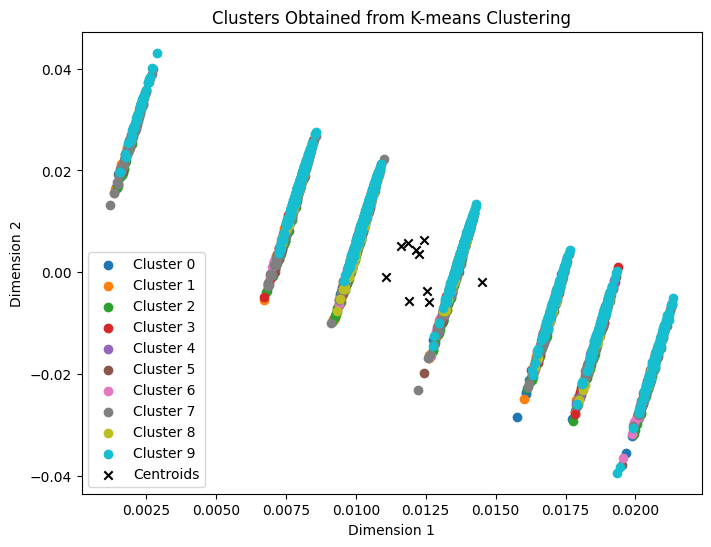

In [33]:
# Plot clusters
# plt.figure(figsize=(10, 6))
# for i in range(10):
#     plt.scatter(U_reduced[cluster_labels == i, 0], U_reduced[cluster_labels == i, 1], label=f'Cluster {i+1}')
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', color='black', s=300, label='Centroids')
# plt.title('K-means Clustering of Users')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.grid(True)
# plt.show()

def plot_clusters(U, cluster_labels, centroids):
    plt.figure(figsize=(8, 6))
    for cluster_label in np.unique(cluster_labels):
        plt.scatter(U[cluster_labels == cluster_label, 0], U[cluster_labels == cluster_label, 1], label=f'Cluster {cluster_label}')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', label='Centroids')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Clusters Obtained from K-means Clustering')
    plt.legend()
    plt.show()

plot_clusters(U[:, :2], cluster_labels, centroids)

In [34]:
# Extract unique values for occupations, age groups, and genres
all_occupations = users_data["occupation"].unique()
all_age_groups = sorted(users_data["age"].unique())
all_genres = set('|'.join(movies_data["genres"]).split('|'))

# Print sample values
print("Unique Occupations:", all_occupations)
print("Unique Age Groups:", all_age_groups)
print("Unique Genres:", all_genres)

Unique Occupations: [10 16 15  7 20  9  1 12 17  0  3 14  4 11  8 19  2 18  5 13  6]
Unique Age Groups: [1, 18, 25, 35, 45, 50, 56]
Unique Genres: {'Adventure', 'Fantasy', 'War', 'Film-Noir', 'Documentary', "Children's", 'Crime', 'Action', 'Horror', 'Mystery', 'Drama', 'Romance', 'Western', 'Sci-Fi', 'Musical', 'Animation', 'Comedy', 'Thriller'}


In [47]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)  # Transpose vector2 to match dimensions
    norm_vector1 = np.linalg.norm(vector1, axis=1, keepdims=True)
    norm_vector2 = np.linalg.norm(vector2, axis=1, keepdims=True)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

In [49]:
def recommend_movies_for_new_user(new_user_info, interested_genres, U, centroids, movies_data):
    # Encode user information into a feature vector
    user_profile = encode_user_profile(new_user_info,interested_genres)



    # # Create a query vector combining user profile with genre preferences
    # genre_indices = genres_to_indices(interested_genres)
    # genre_centroids = centroids[:, genre_indices]
    # query_vector = np.concatenate([user_profile, genre_centroids], axis=1)

    # Calculate cosine similarity between query vector and movie features
    similarity_scores = cosine_similarity(U, user_profile)

    # Rank movies based on similarity scores
    ranked_movie_indices = np.argsort(similarity_scores.ravel())[::-1]

    # Get movie titles and genres for recommended movies
    recommended_movies = movies_data.iloc[ranked_movie_indices[:10]]  # Get top 10 recommended movies

    return recommended_movies

def encode_user_profile(new_user_info,interested_genres):


      #  attributes into a feature vector
      feature_names = user_item_with_features.columns
      user_profile = np.zeros(len(feature_names))

      user_profile['gender_{}'.format(new_user_info['gender'])]=1
      user_profile['occupation_{}'.format(new_user_info['occupation'])]=1
      user_profile['age']=new_user_info['age']
      for genre in interested_genres:
        user_profile[genre]=5

      return user_profile



# Example usage:
new_user_info = {'age': 25, 'gender': 'F', 'occupation': 6}
interested_genres = ['Action', 'Adventure', 'Sci-Fi']

recommended_movies = recommend_movies_for_new_user(new_user_info, interested_genres, U, centroids, movies_data)
print("Recommended Movies:")
print(recommended_movies[['title', 'genres']])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices